# Transition risk and climate risk 

> This project aims at jointly modeling physical and
transition risk within a Merton-like credit risk model, building up on [Bouchet and Le Guenedal, 2020].

<br>

**Target** : Introduce physical risk in the model as a Poisson component variable, whose
jumps are proportional to the total asset value (any alternative may be proposed). You
may consider a simpler model where physical risk occurs only once (with a exponential
law time distribution).

* Assess the additional impact of physical risk on default probabilities

## Merton Model

Il est nécessaire d'initialiser notre modèle avec la valeur de la firme en année 0 : 

*Pour cela on récupère* :

* PD : Probabilité de défault -> Permet de déterminer N1 et N2 
* $\sigma_v$ : Déterminé grâce au cours de l'action 
* V,E,D : récupérés grâce à l'étude des comptes

In [1]:
import numpy as np 
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

## Merton's Inputs

In [55]:
Equity_dict={'Danone': 17241000, 'Nestle':47872200, 'Schlumberger':21136747 , 'Areva': 1248000}

Debt_dict={'Danone': 10927000, 'Nestle':53678780, 'Schlumberger':11292800*0.82 , 'Areva': 1765000}

Scope_dict ={'Danone': 722000, 'Nestle':3290000, 'Schlumberger':2000000 , 'Areva': 260687}

PD_dict={'Danone': 0.08, 'Nestle':0.08, 'Schlumberger':0.08 , 'Areva': 0.08, 'Mistu': 0.08 }

T = 40

In [75]:
import math
def compute_sigma_v(E,D,V,T):
    d1 = -inv_PD
    r=1.56/1000
    a=((-E+V*norm.cdf(d1))/(D*math.exp(-r*T)))
    d2=norm.ppf(a)
    sigma_v=(d1-d2)/np.sqrt(T)
    sigma_e=(V*sigma_v*norm.cdf(d1))/V
    return(sigma_v)

# Introduce carbon tax

3 évolutions de prix possibles - sur l'horizon 2030-2035 (si plus changer maturité)

In [8]:
scenarios = pd.read_excel('scenarios_edited.xlsx')
scenarios = scenarios.set_index('Year')
scenarios.head()

,SSP2-Baseline (3.8°C)-Cout Carbone (US$2010/tCO2),SSP2-Baseline (3.8°C)-Temps de retour températures extrêmes (années),SSP2-Baseline (3.8°C)-Augmentation intensité températures extrêmes,SSP2-34 (2.2°C)-Cout Carbone (US$2010/tCO2),SSP2-34 (2.2°C)-Temps de retour températures extrêmes (années),SSP2-34 (2.2°C)-Augmentation intensité températures extrêmes,SSP2-26 (1.8°C)-Cout Carbone (US$2010/tCO2),SSP2-26 (1.8°C)-Temps de retour températures extrêmes (années),SSP2-26 (1.8°C)-Augmentation intensité températures extrêmes
Year,,,,,,,,,
2021,0,20,0.00,7,20,0.00,7,20,0
2030,0,15,0.02,85,15,0.01,390,17,0
2040,0,10,0.04,135,10,0.02,640,14,0
2050,0,5,0.06,240,5,0.03,1124,11,0
2060,0,2,0.08,390,2,0.04,1850,8,0


### Extract carbon prices 

In [9]:
carbon_cols = scenarios.columns[scenarios.columns.str.contains('Carbone')]
carbon_prices = scenarios[carbon_cols]

### Create array with linspace

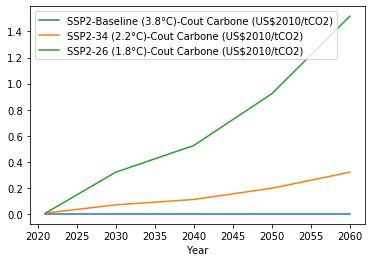

In [10]:
c_prices = {}
for col in carbon_cols :
    tmp = [] # temporary list to store carbon prices
    for i , (year,price) in enumerate(zip(carbon_prices.index,carbon_prices[col])):
        convert_usdeur = 0.82/1000 # Usd to k€  
        if i < len(carbon_prices.index)-1:
            if i==0:
                tmp+=np.linspace(price*convert_usdeur,carbon_prices[col].values[i+1]*convert_usdeur,carbon_prices.index[i+1]-year+1).tolist()
            else :
                tmp+=np.linspace(price*convert_usdeur,carbon_prices[col].values[i+1]*convert_usdeur,carbon_prices.index[i+1]-year+1).tolist()[1:]
    c_prices[col] = tmp
carbon_df = pd.DataFrame(c_prices)
carbon_df.index += 2021
carbon_df = carbon_df.rename_axis("Year")

# Created df with carbon price evolution (linear between gap prices)
carbon_df.plot()
# TODO : legender

# Transition risk  - From carbon tax to asset devaluation

### Need to compute carbon footprint each year : 

* Sum of carbon footprint on each country of activity : i = 0; one company only

$CC(k,t) = \sum_{j\in M} Scope_1(j,t)\times CP(j,k,t) $

k is scenario chosen ; j a region ; t is time

* To simplify our study - Only consider one country ? 

### Shock to EBITDA 

* Firm is equal to a given multiplier times EBITDA 

$\zeta(k,t) = \frac{CC(k,t)}{EBITDA(k=0,t=0)}$

### Link with initial firm value 

$V(k,t) = (1-\zeta(k,t))\times V(k=0,t=0) $

In [11]:
### Create scenario
def create_scenarios(carbon_dict,T):
    ## Create a scenario based on dict : {initial_value1:[growth],initial_value2:[growth]}
    carbon_scenarios = [] # Stores all carbon scenario 
    for (i,base_value) in enumerate(carbon_dict):
        for (j,growth_rate) in enumerate(carbon_dict[base_value]):
            scenario = [base_value*(1+growth_rate)**t for t in range(T)]
            carbon_scenarios.append(scenario)
    return(carbon_scenarios)

### Plot scenarios
def plot_scenarios(carbon_scenarios,T,prefix='Carbon tax',ylabel='Carbon tax [USD]'):
    time  = [i+2021 for i in range(T)]
    for (i,scenario) in enumerate(carbon_scenarios):
        plt.plot(time,scenario,label=f"{prefix} {i+1}")
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

## Compute each carbon cost for each scenario

In [47]:
def compute_carbon_cost(carbon_scenarios,firm_scenario):
    """Carbon scenarios : liste des prix du carbone sur la durée de temps considérée
       Firm scenario : Trajectoire de décarbonation envisagé par l'entreprise
       
    Output : array avec le coût de chaque possibilité"""
    results = {}
    for (i,carbon_tax) in enumerate(carbon_scenarios):
        ## Loop on each carbon tax & compute a price 
        for (j,scenario) in enumerate(firm_scenario):
            cost = []
            for (carbon_price,scope) in zip(carbon_tax,scenario):
                cost.append(carbon_price*scope)
            results[f'scenario_{i}_{j}'] = cost # scenario i (which carbon tax) ; j (which alignement scenario)
    return(results)

### Compute zeta & PD 

In [21]:
import math
# Only transition risk
def compute_pd_transition(carbon_cost,V,D,multiple=6,T=1,PD0=0.02,sigma_v=0.5,r=0):
    # list of zeta, compute evolution of PD
    PD = [PD0]
    for i in range(1,len(carbon_cost)):
        zeta = carbon_cost[i]/(V/multiple)
        if zeta > 1 :
            #### Cannot handle carbon tax : 
            PD.append(1)
        # Compute pd ième 
        else:
            DD = ( np.log( (1-zeta)*V/D )+ (r+0.5*sigma_v**2)*T )/(sigma_v*np.sqrt(T))
            pdi = norm.cdf(-DD)
            PD.append(pdi)             
    return(PD)

## Physical risk


Sur l'horizon des 40 années, une catastrophe arrive 

* L'année t est choisie avec une loi de poisson ? ou random au bout 2035-2060.

#### Amplitude dépend du scénario de transition : 

* 20% de la valeur des actifs si prix carbon bas (BaU) (**edit**: modifié à 84% car sinon rien de probant)
* 10% de la valeur des assets si prix carbon medium
* 4% de la valeur des assets si prix carbon haut


In [25]:
# Gabriel
def compute_poisson_loss(V,scenario):
    # Calcul de la perte liée au risque physique
    """Scenario 0 : BaU
       Scenario 1 : Medium
       Scenario 2 : Low """
    Temps=40
    Freq0={0:1/15, 1:1/10, 2:1/5, 3:1/2}
    Freq1={0:1/15, 1:1/10, 2:1/5, 3:1/2}
    Freq2={0:1/17, 1:1/14, 2:1/11, 3:1/8}
    AmplitudePerte= {0:0.12, 1:0.08, 2:0.04}##correspond au 1-zeta, zeta =PertePhysique/ebtitda
     
    Frequence={0:Freq0, 1:Freq1, 2:Freq2}
    f=Frequence[scenario]

    N=10
  
    #xk est une liste de 10 éléments, 10 pour 10 ans etk l'intervalle x2 c'est de 2030 à 2040,
    #Chaque élément de la liste correpond au nombre de secheresse par an 
    x0=np.random.poisson(f[0],N)
    x1=np.random.poisson(f[1],N)
    x2=np.random.poisson(f[2],N)
    x3=np.random.poisson(f[3],N)


    loss=np.zeros(Temps+1)

    #Calcul une liste avec les différents V en fonction du temps 
    for k in range(N):
        loss[k+1]=-x0[k]*AmplitudePerte[scenario]*V
        ##Ci dessus le calcul de la perte un pourcentage de V, fois le nombre de secheresse

    for k in range(N):
        loss[k+1+N]=-x1[k]*AmplitudePerte[scenario]*V


    for k in range(N):
        loss[k+1+2*N]=-x2[k]*AmplitudePerte[scenario]*V

    for k in range(N):
        loss[k+1+3*N]=-x3[k]*AmplitudePerte[scenario]*V
      
  
    poisson_dict = loss
    #"""Return a dict to access easily to data"""
    return(poisson_dict)

### Add physical risk to probability of default

In [41]:
import math
carbon_cost=np.zeros(41)
# Calcul de la PD avec un risque physique
def compute_pd1RisquePhysique(V,scenario,sigma_v,r,T,D):
    loss=compute_poisson_loss(V,scenario)
    VV=np.zeros(len(loss))
    PD=np.zeros(len(loss))
    DD=np.zeros(len(loss))
    VV[0]=V
    for k in range(1,len(loss)):
        VV[k]=VV[k-1]+loss[k]

    for i in range(len(VV)):
        DD[i] = (np.log( VV[i]/D )+ (r+0.5*sigma_v**2)*T )/(sigma_v*np.sqrt(T))
        if VV[i]/D > 0:
            PD[i]=norm.cdf(-DD[i])
        else : 
            PD[i]=1
    return(PD)

# Couplage risque physique & risque de transition
def compute_pd1RisquePhysiqueTransition(V,scenario,sigma_v,r,T,D,carbon_cost,multiple):
    loss=compute_poisson_loss(V,scenario)
    VV=np.zeros(len(loss))
    PD=np.zeros(T)
    DD=np.zeros(T)
    VV[0]=V
    for k in range(1,len(loss)):
        VV[k]=VV[k-1]+loss[k]
    VV = VV[1:]
    for i in range(len(VV)):
        zeta = carbon_cost[i]/(V/multiple)
        ### VV[i]/V = 1-zeta'
        ### Pas de calcul de DD si (VV[i]/V - zeta) < 0
        if VV[i]/V-zeta <0:
            PD[i] = 1 # défault 
        else :
            DD[i] = (np.log( (((VV[i]/V)-zeta)*V)/D )+ (r+0.5*sigma_v**2)*T )/(sigma_v*np.sqrt(T))
            pdi = norm.cdf(-DD[i])
            PD[i] = pdi
    return(PD)

In [97]:
def analyse_pd_firm(carbon_df,V,D,T,PD_value,multiple,firm_dict,prefix):
    r = 1.56/1000
    sigma_v = compute_sigma_v(E,D,V,T)  # Compute using merton model
    """Utiliser d'autres"""
    r = 0
    sigma_v = 0.2
    """Input V,D,T,firm_dict,sigma_v,r,prefix (for plot)"""
    ### First create scenarios for carbon decarbonation : 
    firm_carbon_scenario = create_scenarios(firm_dict,T)
    """Plot some scenarios"""
    plot_scenarios(firm_carbon_scenario,T=T,prefix=prefix,ylabel='TCo2Eq')
    ## Compute cost of carbon per year regarding carbon_tax price 
    array_carbon_df = [carbon_df[col].tolist() for col in carbon_df.columns]
    cost = compute_carbon_cost(array_carbon_df,firm_carbon_scenario) #array with cost of carbon
    # df contains scenario_i_j : i carbon price trajectoire, j firm carbon scope
    df = pd.DataFrame(cost)
    df.index = carbon_df.index
    
    ##### First part : transition risk only #####
    
    prob_defaults_transition_only = []
    time = df.index.tolist()
    for (i,col) in enumerate(df.columns) : 
        prob_defaults_transition_only.append(compute_pd_transition(df.iloc[:,i].values,V,D,multiple=multiple,T=T,PD0=PD_value,sigma_v=sigma_v,r=r))
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    for i,pd_ar in enumerate(prob_defaults_transition_only) :
        plt.plot(time,pd_ar,label=df.columns[i])
    plt.legend()
    plt.title("PD en fonction du couple carbon & décarbonation")
    plt.subplot(122)
    for col in df.columns:
        plt.plot(time,df[col],label = col)
    plt.title("Coût fonction du couple carbon & décarbonation")
    plt.legend()
    plt.show()
    
    ##### Second part : physical risk only #####
    
    prob_defaults_physical_only = []
    for i in range(3) : # 3 scenarios for physical risk to deal with 
        prob_defaults_physical_only.append(compute_pd1RisquePhysique(V,i,sigma_v,r,T,D))
    """plot these prob of defaults"""
    time1 = [i+2020 for i in range(len(prob_defaults_physical_only[0]))]
    for i,pd_ar in enumerate(prob_defaults_physical_only) :
            plt.plot(time1,pd_ar,label=f'Scenario {i}')
    plt.title("PD et risque physique")
    
    #### Third part : transition & physical together ####
    prob_defaults_physical_transition = []
    
    for (i,col) in enumerate(df.columns) : 
        nb_scenario = int(col.split('_')[1]) # scenario_i_j -> scenario (i[1]) j
        prob_defaults_physical_transition.append(compute_pd1RisquePhysiqueTransition(V,nb_scenario,sigma_v,r,T,D,df.iloc[:,i].values,multiple))
    plt.figure(figsize=(20,5))
    
    for i,pd_ar in enumerate(prob_defaults_transition_only) :
        plt.plot(time,pd_ar,label=df.columns[i])
    plt.legend()
    plt.title("PD - transition & physical risk")

### Simulation 

### Danone

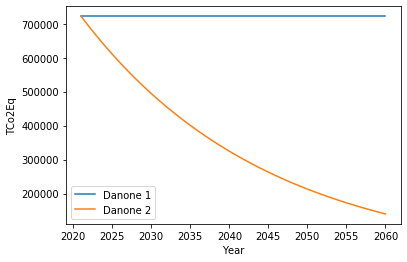

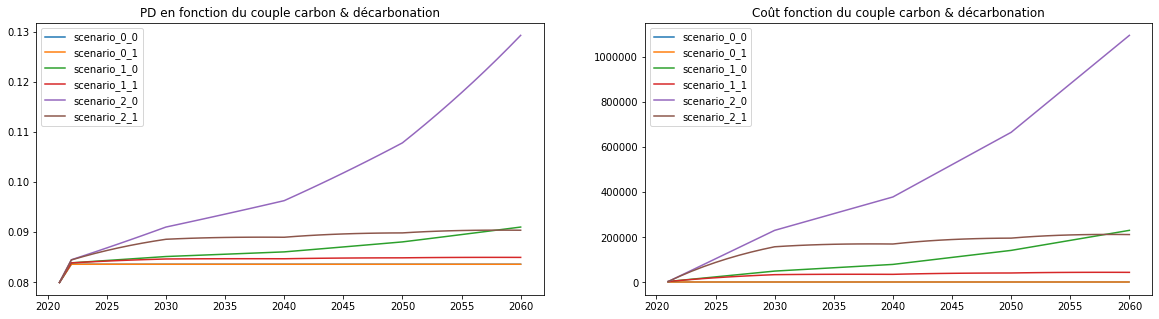

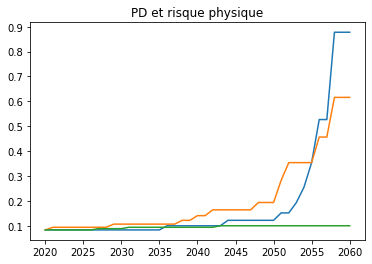

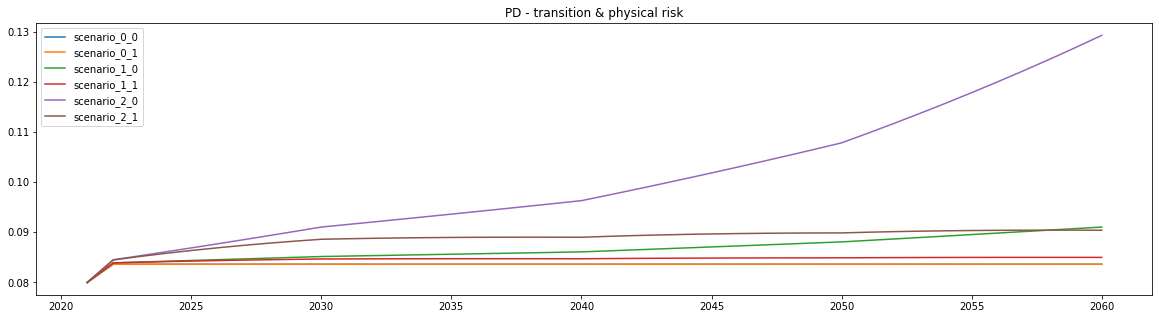

In [104]:
firm = 'Danone'
E= Equity_dict[firm] # Asset value 
D = Debt_dict[firm] # Equity value 
V = D+E #Debt value
T = 40 # Maturity - Horizon 2020 - 2060
PD_value=PD_dict[firm]
danone_dict = {Scope_dict[firm]:[0,-0.0412]} # danone : 722kTCo2 - Constant vs décroissance de 4.12%/an (actuelle de Danone)
analyse_pd_firm(carbon_df,V,D,T,PD_value,7,danone_dict,prefix=firm)

## Nestlé

In [ ]:
firm = 'Danone'
E= Equity_dict[firm] # Asset value 
D = Debt_dict[firm] # Equity value 
V = D+E #Debt value
T = 40 # Maturity - Horizon 2020 - 2060
PD_value=PD_dict[firm]
danone_dict = {Scope_dict[firm]:[0,-0.0412]} # danone : 722kTCo2 - Constant vs décroissance de 4.12%/an (actuelle de Danone)
analyse_pd_firm(carbon_df,V,D,T,PD_value,7,danone_dict,prefix=firm)

## Schlumberger

In [105]:
firm = 'Danone'
E= Equity_dict[firm] # Asset value 
D = Debt_dict[firm] # Equity value 
V = D+E #Debt value
T = 40 # Maturity - Horizon 2020 - 2060
PD_value=PD_dict[firm]
danone_dict = {Scope_dict[firm]:[0,-0.0412]} # danone : 722kTCo2 - Constant vs décroissance de 4.12%/an (actuelle de Danone)
analyse_pd_firm(carbon_df,V,D,T,PD_value,7,danone_dict,prefix=firm)

dict_keys(['Danone', 'Nestle', 'Schlumberger', 'Areva'])

## Areva

In [ ]:
firm = 'Danone'
E= Equity_dict[firm] # Asset value 
D = Debt_dict[firm] # Equity value 
V = D+E #Debt value
T = 40 # Maturity - Horizon 2020 - 2060
PD_value=PD_dict[firm]
danone_dict = {Scope_dict[firm]:[0,-0.0412]} # danone : 722kTCo2 - Constant vs décroissance de 4.12%/an (actuelle de Danone)
analyse_pd_firm(carbon_df,V,D,T,PD_value,7,danone_dict,prefix=firm)